In [1]:
import pennylane as qml
import random
import os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
os.chdir('../')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cuda


# Quantum Circuit

In [4]:
date = '20211122_120334'

resume_iters = 30

test_sample_size = 100000

layer = 2

qubits = 8

In [5]:
dev = qml.device('default.qubit', wires=qubits)
@qml.qnode(dev, interface='torch', diff_method='backprop')
def gen_circuit(w):
    # random noise as generator input
    z1 = random.uniform(-1, 1)
    z2 = random.uniform(-1, 1)
    
    # construct generator circuit for both atom vector and node matrix
    for i in range(qubits):
        qml.RY(np.arcsin(z1), wires=i)
        qml.RZ(np.arcsin(z2), wires=i)
    for l in range(layer):
        for i in range(qubits):
            qml.RY(w[i], wires=i)
        for i in range(qubits-1):
            qml.CNOT(wires=[i, i+1])
            qml.RZ(w[i+qubits], wires=i+1)
            qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

In [6]:
model_dir_path = r'/home/ken/projects/QuantumGAN-PyTorch/results/quantum-GAN/'+date+'/train/model_dir'

weights_pth = os.path.join(model_dir_path, 'molgan_red_weights.csv')

weights = pd.read_csv(weights_pth, header=None).iloc[resume_iters-1, 1:].values

gen_weights = torch.tensor(list(weights), requires_grad=True)

In [7]:
sample_list = [gen_circuit(gen_weights) for i in range(test_sample_size)]

In [8]:
sample_list[0]

tensor([ 0.5648,  0.1830, -0.4142, -0.0337,  0.7679,  0.7447,  0.9254,  0.7108],
       dtype=torch.float64, grad_fn=<CatBackward>)

# Data

In [9]:
from data.sparse_molecular_dataset import SparseMolecularDataset

In [10]:
mol_data_dir = 'data/gdb9_9nodes.sparsedataset'

In [11]:
data = SparseMolecularDataset()

data.load(mol_data_dir)

# Generator

In [12]:
from models.models import Generator, Discriminator

In [13]:
complexity = 'mr'

z_dim = qubits

dropout = 0.0

In [14]:
if complexity == 'nr':
    g_conv_dim = [128, 256, 512]
elif complexity == 'mr':
    g_conv_dim = [128]
elif complexity == 'hr':
    g_conv_dim = [16]
else:
    raise ValueError("Please enter an valid model complexity from 'mr', 'hr' or 'nr'!")

In [15]:
G = Generator(g_conv_dim, z_dim, data.vertexes, data.bond_num_types, data.atom_num_types, dropout)

In [16]:
G.to(device)

Generator(
  (activation_f): Tanh()
  (multi_dense_layers): MultiDenseLayers(
    (activation): Tanh()
    (linear_layers): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.0, inplace=False)
    )
  )
  (edges_layer): Linear(in_features=128, out_features=405, bias=True)
  (nodes_layer): Linear(in_features=128, out_features=45, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [17]:
G_path = os.path.join(model_dir_path, '{}-G.ckpt'.format(resume_iters))

In [18]:
G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))

<All keys matched successfully>

# Generating Molecules

In [19]:
import torch.nn.functional as F

In [20]:
z = torch.stack(tuple(sample_list)).to(device).float()

In [21]:
post_method = 'softmax'

In [22]:
edges_logits, nodes_logits = G(z)

In [23]:
def postprocess(inputs, method, temperature=1.0):
    def listify(x):
        return x if type(x) == list or type(x) == tuple else [x]
    def delistify(x):
        return x if len(x) > 1 else x[0]
    if method == 'soft_gumbel':
        softmax = [F.gumbel_softmax(e_logits.contiguous().view(-1, e_logits.size(-1))/temperature, hard=False).view(e_logits.size()) for e_logits in listify(inputs)]
    elif method == 'hard_gumbel':
        softmax = [F.gumbel_softmax(e_logits.contiguous().view(-1, e_logits.size(-1))/temperature, hard=True).view(e_logits.size()) for e_logits in listify(inputs)]
    else:
        softmax = [F.softmax(e_logits/temperature, -1) for e_logits in listify(inputs)]
    return [delistify(e) for e in (softmax)]

In [24]:
(edges_hat, nodes_hat) = postprocess((edges_logits, nodes_logits), post_method)   

In [25]:
def get_gen_mols(data, n_hat, e_hat, method):
    (edges_hard, nodes_hard) = postprocess((e_hat, n_hat), method)
    edges_hard, nodes_hard = torch.max(edges_hard, -1)[1], torch.max(nodes_hard, -1)[1]
    mols = [data.matrices2mol(n_.data.cpu().numpy(), e_.data.cpu().numpy(), strict=True) for e_, n_ in zip(edges_hard, nodes_hard)]
    return mols

In [26]:
mols = get_gen_mols(data, nodes_logits, edges_logits, post_method)

RDKit ERROR: [14:00:47] non-ring atom 1 marked aromatic
[14:00:47] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:47] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:47] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:47] Explicit valence for atom # 8 C, 5, is greater than permitted
[14:00:47] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [14:00:47] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:47] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:47] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:00:47] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:00:47] non-ring atom 0 marked aromatic
[14:00:47] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:47] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:00:47] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14

RDKit ERROR: [14:00:47] non-ring atom 0 marked aromatic
[14:00:47] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:47] non-ring atom 0 marked aromatic
[14:00:47] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:47] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
RDKit ERROR: [14:00:47] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:47] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

[14:00:47] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:00:47] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:00:47] non-ring atom 0 marked aromatic
[14:00:47] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:47] Can't kekulize mol.  Unkekulized atoms: 4 6 8
[14:00:47] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:00:47] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:

RDKit ERROR: [14:00:48] non-ring atom 0 marked aromatic
[14:00:48] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:48] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:00:48] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:00:48] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:48] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:48] non-ring atom 1 marked aromatic
[14:00:48] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:48] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:48] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:48] non-ring atom 0 marked aromatic
[14:00:48] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:48] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:00:48] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:00:48] Explicit valence for atom # 2 O, 3, is grea

RDKit ERROR: [14:00:48] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:00:48] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:00:48] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:48] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:48] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:48] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:48] non-ring atom 0 marked aromatic
[14:00:48] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:48] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:00:48] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:00:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:00:48] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:00:48] Explicit valence for atom # 8 C, 5, is greater than permitted
[14:00:48] Explicit 

RDKit ERROR: [14:00:48] non-ring atom 0 marked aromatic
[14:00:48] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:48] Explicit valence for atom # 5 O, 4, is greater than permitted
[14:00:48] Explicit valence for atom # 5 O, 4, is greater than permitted
RDKit ERROR: [14:00:48] non-ring atom 0 marked aromatic
[14:00:48] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:48] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:00:48] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:00:48] Explicit valence for atom # 3 O, 3, is greater than permitted
[14:00:48] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [14:00:48] Can't kekulize mol.  Unkekulized atoms: 0 1 8
RDKit ERROR: 
[14:00:48] Can't kekulize mol.  Unkekulized atoms: 0 1 8

RDKit ERROR: [14:00:48] non-ring atom 3 marked aromatic
[14:00:48] non-ring atom 3 marked aromatic
RDKit ERROR: [14:00:48] non-ring atom 1 marked aromatic
[14:00:48] non-ring atom 1 m

RDKit ERROR: [14:00:48] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:00:48] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:00:48] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:00:48] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:00:48] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:48] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:48] non-ring atom 0 marked aromatic
[14:00:48] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:48] non-ring atom 5 marked aromatic
[14:00:48] non-ring atom 5 marked aromatic
RDKit ERROR: [14:00:48] non-ring atom 0 marked aromatic
[14:00:48] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:48] Explicit valence for atom # 0 O, 3, is greater than permitted
[14:00:48] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [14:00:48] non-ring atom 0 marked aromatic
[14:00:48] 

[14:00:48] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:48] non-ring atom 0 marked aromatic
[14:00:48] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:48] non-ring atom 0 marked aromatic
[14:00:48] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:48] non-ring atom 0 marked aromatic
[14:00:48] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:48] non-ring atom 1 marked aromatic
[14:00:48] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:48] non-ring atom 1 marked aromatic
[14:00:48] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:48] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:00:48] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:00:48] Can't kekulize mol.  Unkekulized atoms: 4 6 8
[14:00:48] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:00:48] non-ring atom 0 marked aromatic
[14:00:48] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:48] Explicit valence for atom # 2 O, 3, is

RDKit ERROR: [14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:49] non-ring atom 0 marked aromatic
[14:00:49] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:49] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:49] non-ring atom 0 marked aromatic
[14:00:49] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit E

RDKit ERROR: [14:00:49] non-ring atom 1 marked aromatic
[14:00:49] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:49] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:00:49] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:00:49] non-ring atom 1 marked aromatic
[14:00:49] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:49] Can't kekulize mol.  Unkekulized atoms: 4 6 8
[14:00:49] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:49] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:00:49] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:00:49] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:00:49] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: 
RDKit ERROR: [14:00:49] non-ring atom 1 marked aro

RDKit ERROR: [14:00:49] non-ring atom 1 marked aromatic
[14:00:49] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:49] Can't kekulize mol.  Unkekulized atoms: 0 2 8
RDKit ERROR: 
[14:00:49] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: [14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:49] non-ring atom 0 marked aromatic
[14:00:49] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:49] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:49] non-ring atom 1 marked aromatic
[14:00:49] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:49] non-ring atom 1 marked aromatic
[14:00:49] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:49] Explicit valence for atom # 2 O, 3, is greater 

RDKit ERROR: 
RDKit ERROR: [14:00:49] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:00:49] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:00:49] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:49] non-ring atom 1 marked aromatic
[14:00:49] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:49] non-ring atom 0 marked aromatic
[14:00:49] non-ring atom 0 marked ar

RDKit ERROR: [14:00:49] non-ring atom 0 marked aromatic
[14:00:49] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:49] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:49] Explicit valence for atom # 0 O, 3, is greater than permitted
[14:00:49] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:49] non-ring atom 0 marked aromatic
[14:00:49] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:49] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:49] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
[14:00:49] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: 
RDKit ERROR: [14

RDKit ERROR: [14:00:50] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:50] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:50] Explicit valence for atom # 5 O, 4, is greater than permitted
[14:00:50] Explicit valence for atom # 5 O, 4, is greater than permitted
RDKit ERROR: [14:00:50] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:00:50] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:00:50] non-ring atom 1 marked aromatic
[14:00:50] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:50] non-ring atom 0 marked aromatic
[14:00:50] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:50] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:50] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:50] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:50] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit E

RDKit ERROR: [14:00:50] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:50] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:50] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:00:50] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:00:50] non-ring atom 0 marked aromatic
[14:00:50] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:50] non-ring atom 0 marked aromatic
[14:00:50] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:50] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:00:50] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:00:50] non-ring atom 1 marked aromatic
[14:00:50] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:50] non-ring atom 1 marked aromatic
[14:00:50] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:50] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:00:50] Explicit valence for atom # 7 O, 4, is 

RDKit ERROR: [14:00:50] non-ring atom 1 marked aromatic
[14:00:50] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:50] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:00:50] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:00:50] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:00:50] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:00:50] non-ring atom 0 marked aromatic
[14:00:50] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:50] Explicit valence for atom # 6 O, 3, is greater than permitted
[14:00:50] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [14:00:50] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:50] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:50] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:00:50] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit E

RDKit ERROR: [14:00:50] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:50] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:50] non-ring atom 0 marked aromatic
[14:00:50] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:50] non-ring atom 1 marked aromatic
[14:00:50] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:50] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
[14:00:50] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:00:50] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:00:50] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:00:50] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:00:50] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:00:50] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:00:50] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: 
RDKit ERROR: [14:00:50] non-ring 

RDKit ERROR: [14:00:50] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:50] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:50] non-ring atom 1 marked aromatic
[14:00:50] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:50] non-ring atom 0 marked aromatic
[14:00:50] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:50] non-ring atom 0 marked aromatic
[14:00:50] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:50] non-ring atom 1 marked aromatic
[14:00:50] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:50] non-ring atom 0 marked aromatic
[14:00:50] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:50] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:00:50] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:00:50] non-ring atom 1 marked aromatic
[14:00:50] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:50] Can't kekulize mol.  Unkekulized atoms: 0 6 8
[14:00:50] Can't k

RDKit ERROR: [14:00:51] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:51] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:51] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:51] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:51] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:00:51] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:00:51] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:00:51] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:00:51] non-ring atom 1 marked aromatic
[14:00:51] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:51] Explicit valence for atom # 5 O, 3, is greater than permitted
[14:00:51] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [14:00:51] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:51] Explicit 

RDKit ERROR: [14:00:51] non-ring atom 1 marked aromatic
[14:00:51] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:51] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:51] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:51] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:51] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:51] non-ring atom 0 marked aromatic
[14:00:51] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:51] non-ring atom 1 marked aromatic
[14:00:51] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:51] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:51] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:51] non-ring atom 1 marked aromatic
[14:00:51] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:51] non-ring atom 1 marked aromatic
[14:00:51] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:51] non-

RDKit ERROR: [14:00:51] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:51] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:51] non-ring atom 0 marked aromatic
[14:00:51] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:51] Explicit valence for atom # 8 O, 3, is greater than permitted
[14:00:51] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [14:00:51] Can't kekulize mol.  Unkekulized atoms: 8
[14:00:51] Can't kekulize mol.  Unkekulized atoms: 8

RDKit ERROR: 
RDKit ERROR: [14:00:51] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:51] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:51] Explicit valence for atom # 8 O, 3, is greater than permitted
[14:00:51] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [14:00:51] non-ring atom 1 marked aromatic
[14:00:51] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:51] non-ring

RDKit ERROR: [14:00:51] non-ring atom 0 marked aromatic
[14:00:51] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:51] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:51] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:51] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:51] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:51] non-ring atom 0 marked aromatic
[14:00:51] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:51] non-ring atom 1 marked aromatic
[14:00:51] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:51] Can't kekulize mol.  Unkekulized atoms: 4 6 8
[14:00:51] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:00:51] non-ring atom 0 marked aromatic
[14:00:51] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:51] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:51] Explicit valence for atom # 2 O, 3, is greater 

RDKit ERROR: [14:00:51] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:51] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:51] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:51] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:51] non-ring atom 1 marked aromatic
[14:00:51] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:51] non-ring atom 0 marked aromatic
[14:00:51] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:51] non-ring atom 0 marked aromatic
[14:00:51] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:51] non-ring atom 1 marked aromatic
[14:00:51] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:51] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:51] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:51] non-ring atom 0 marked aromatic
[14:00:51] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:51] Expl

RDKit ERROR: [14:00:52] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:52] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:52] Explicit valence for atom # 8 C, 5, is greater than permitted
[14:00:52] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [14:00:52] non-ring atom 1 marked aromatic
[14:00:52] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:52] non-ring atom 0 marked aromatic
[14:00:52] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:52] non-ring atom 0 marked aromatic
[14:00:52] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:52] non-ring atom 0 marked aromatic
[14:00:52] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:52] Explicit valence for atom # 3 O, 3, is greater than permitted
[14:00:52] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [14:00:52] non-ring atom 1 marked aromatic
[14:00:52] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:52] non-

RDKit ERROR: [14:00:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:00:52] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:00:52] non-ring atom 0 marked aromatic
[14:00:52] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:52] non-ring atom 1 marked aromatic
[14:00:52] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:52] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:52] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:52] non-ring atom 1 marked aromatic
[14:00:52] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:52] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
[14:00:52] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:00:52] Explicit valence for atom # 8 C, 5, is greater than permitted
[14:00:52] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [14:00:52] non-ring atom 1 marked aromatic
[14:00:52] non-ring 

RDKit ERROR: [14:00:52] non-ring atom 0 marked aromatic
[14:00:52] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:00:52] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:00:52] non-ring atom 0 marked aromatic
[14:00:52] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:52] non-ring atom 0 marked aromatic
[14:00:52] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:00:52] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:00:52] non-ring atom 0 marked aromatic
[14:00:52] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:52] non-ring atom 1 marked aromatic
[14:00:52] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:52] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:52] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:52] non-

[14:00:52] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:52] non-ring atom 1 marked aromatic
[14:00:52] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:52] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:00:52] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:00:52] Can't kekulize mol.  Unkekulized atoms: 0 1 8
[14:00:52] Can't kekulize mol.  Unkekulized atoms: 0 1 8

RDKit ERROR: 
RDKit ERROR: [14:00:52] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:00:52] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:00:52] Can't kekulize mol.  Unkekulized atoms: 4 6 8
RDKit ERROR: 
[14:00:52] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: [14:00:52] Explicit valence for atom # 5 O, 4, is greater than permitted
[14:00:52] Explicit valence for atom # 5 O, 4, is greater than permitted
RDKit ERROR: [14:00:52] non-ring atom 0 marked aromatic
[14:00:52] non-ring atom 0 marked aromati

RDKit ERROR: [14:00:52] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:52] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:52] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:52] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:52] non-ring atom 0 marked aromatic
[14:00:52] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:52] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:52] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:52] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:00:52] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:00:52] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:00:52] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:00:52] non-ring atom 0 marked aromatic
[14:00:52] non-ring atom 0 marked aromatic
RDKit E

RDKit ERROR: [14:00:53] non-ring atom 1 marked aromatic
[14:00:53] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:53] non-ring atom 0 marked aromatic
[14:00:53] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:53] non-ring atom 1 marked aromatic
[14:00:53] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:53] non-ring atom 1 marked aromatic
[14:00:53] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:53] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:00:53] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:00:53] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
[14:00:53] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:00:53] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:53] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:53] non-ring atom 1 marked aromatic
[14:00:53] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:53] Explicit vale

RDKit ERROR: [14:00:53] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:53] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:53] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:53] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:53] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:00:53] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: 
RDKit ERROR: [14:00:53] non-ring atom 0 marked aromatic
[14:00:53] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:53] Explicit valence for atom # 8 O, 3, is greater than permitted
[14:00:53] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [14:00:53] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:53] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:53] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:53] Explicit valence for atom 

[14:00:53] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:53] Can't kekulize mol.  Unkekulized atoms: 0 2 8
RDKit ERROR: 
[14:00:53] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: [14:00:53] non-ring atom 3 marked aromatic
[14:00:53] non-ring atom 3 marked aromatic
RDKit ERROR: [14:00:53] non-ring atom 1 marked aromatic
[14:00:53] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:53] non-ring atom 1 marked aromatic
[14:00:53] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:53] non-ring atom 1 marked aromatic
[14:00:53] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:53] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:53] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:53] non-ring atom 1 marked aromatic
[14:00:53] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:53] non-ring atom 1 marked aromatic
[14:00:53] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:53] Explicit

RDKit ERROR: [14:00:53] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:00:53] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:00:53] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:00:53] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:00:53] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:00:53] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: 
RDKit ERROR: [14:00:53] non-ring atom 0 marked aromatic
[14:00:53] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:53] non-ring atom 1 marked aromatic
[14:00:53] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:53] non-ring atom 0 marked aromatic
[14:00:53] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:53] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:53] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:53] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
[14:00:53] Can't ke

RDKit ERROR: [14:00:54] non-ring atom 0 marked aromatic
[14:00:54] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:54] non-ring atom 1 marked aromatic
[14:00:54] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:54] non-ring atom 0 marked aromatic
[14:00:54] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:54] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
[14:00:54] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:00:54] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:00:54] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:00:54] non-ring atom 0 marked aromatic
[14:00:54] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:54] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:00:54] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:00:54] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:00:54] Explicit valence for atom # 6 C, 5, is greater t

RDKit ERROR: [14:00:54] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:00:54] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:00:54] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:54] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:54] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:00:54] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:00:54] Explicit valence for atom # 0 O, 3, is greater than permitted
[14:00:54] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [14:00:54] Can't kekulize mol.  Unkekulized atoms: 0 1 8
[14:00:54] Can't kekulize mol.  Unkekulized atoms: 0 1 8

RDKit ERROR: 
RDKit ERROR: [14:00:54] non-ring atom 0 marked aromatic
[14:00:54] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:54] non-ring atom 1 marked aromatic
[14:00:54] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:54] 

RDKit ERROR: [14:00:54] non-ring atom 0 marked aromatic
[14:00:54] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:54] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:54] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:54] non-ring atom 1 marked aromatic
[14:00:54] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:54] non-ring atom 0 marked aromatic
[14:00:54] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:54] non-ring atom 1 marked aromatic
[14:00:54] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:54] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:00:54] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:00:54] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:00:54] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:00:54] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:54] Explicit valence for atom # 2 

RDKit ERROR: [14:00:54] Can't kekulize mol.  Unkekulized atoms: 0 2 8
RDKit ERROR: 
[14:00:54] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: [14:00:54] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:54] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:54] Can't kekulize mol.  Unkekulized atoms: 4 6 8
[14:00:54] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:00:54] non-ring atom 0 marked aromatic
[14:00:54] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:54] non-ring atom 0 marked aromatic
[14:00:54] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:54] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:54] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:54] non-ring atom 1 marked aromatic
[14:00:54] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:54] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:00:54] Expl

RDKit ERROR: [14:00:54] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:54] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:54] non-ring atom 1 marked aromatic
[14:00:54] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:54] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:54] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:54] non-ring atom 0 marked aromatic
[14:00:54] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:54] non-ring atom 0 marked aromatic
[14:00:54] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:00:54] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:00:54] non-ring atom 0 marked aromatic
[14:00:54] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:54] Explicit valence for atom # 8 O, 3, is greater than permitted
[14:00:54] Explicit valence for atom # 8 

RDKit ERROR: [14:00:55] non-ring atom 0 marked aromatic
[14:00:55] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:55] non-ring atom 1 marked aromatic
[14:00:55] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:55] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:00:55] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:00:55] Can't kekulize mol.  Unkekulized atoms: 4 6 8
RDKit ERROR: 
[14:00:55] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: [14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:55] Can't kekulize mol.  Unkekulized atoms: 0 1 8
[14:00:55] Can't kekulize mol.  Unkekulized atoms: 0 1 8

RDKit ERROR: 
RDKit ERROR: [14:00:55] non-ring atom 0 m

RDKit ERROR: [14:00:55] non-ring atom 0 marked aromatic
[14:00:55] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:55] non-ring atom 1 marked aromatic
[14:00:55] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:55] non-ring atom 1 marked aromatic
[14:00:55] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:55] non-ring atom 0 marked aromatic
[14:00:55] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:55] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:00:55] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:00:55] non-ring atom 0 marked aromatic
[14:00:55] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:55] non-ring atom 0 marked aromatic
[14:00:55] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:55] non-ring atom 1 marked aromatic
[14:00:55] non-ring atom 1 marke

[14:00:55] non-ring atom 1 marked aromatic
[14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:55] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:00:55] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:55] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:55] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:55] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:55] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:55] Can't kekulize mol.  Unkekulized at

RDKit ERROR: [14:00:55] non-ring atom 0 marked aromatic
[14:00:55] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:55] non-ring atom 0 marked aromatic
[14:00:55] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:55] non-ring atom 1 marked aromatic
[14:00:55] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:55] Can't kekulize mol.  Unkekulized atoms: 0 1 3
[14:00:55] Can't kekulize mol.  Unkekulized atoms: 0 1 3

RDKit ERROR: 
RDKit ERROR: [14:00:55] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:00:55] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:00:55] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:00:55] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: 
RDKit ERROR: [14:00:55] non-ring atom 0 marked aromatic
[14:00:55] non-ring atom 0 marked aromatic
RD

RDKit ERROR: [14:00:55] non-ring atom 0 marked aromatic
[14:00:55] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:55] non-ring atom 0 marked aromatic
[14:00:55] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:55] non-ring atom 0 marked aromatic
[14:00:55] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:55] non-ring atom 0 marked aromatic
[14:00:55] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:55] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:55] non-ring atom 1 marked aromatic
[14:00:55] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:55] non-

RDKit ERROR: [14:00:56] non-ring atom 1 marked aromatic
[14:00:56] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:56] Can't kekulize mol.  Unkekulized atoms: 4 6 8
RDKit ERROR: 
[14:00:56] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: [14:00:56] non-ring atom 0 marked aromatic
[14:00:56] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:56] Can't kekulize mol.  Unkekulized atoms: 4 6 8
[14:00:56] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:00:56] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:00:56] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:00:56] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:56] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:56] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:56] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:56] non-ring atom 0 m

RDKit ERROR: [14:00:56] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:56] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:56] Can't kekulize mol.  Unkekulized atoms: 4 6 8
RDKit ERROR: 
[14:00:56] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: [14:00:56] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:00:56] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:00:56] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:00:56] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:00:56] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:00:56] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:00:56] Can't kekulize mol.  Unkekulized atoms: 0 1 8
RDKit ERROR: 
[14:00:56] Can't kekulize mol.  Unkekulized atoms: 0 1 8

RDKit ERROR: [14:00:56] Explicit valence for atom # 2 O, 3, is greater than permitted
[14

RDKit ERROR: [14:00:56] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:56] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:56] non-ring atom 0 marked aromatic
[14:00:56] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:56] non-ring atom 0 marked aromatic
[14:00:56] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:56] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:00:56] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:00:56] Explicit valence for atom # 6 O, 3, is greater than permitted
[14:00:56] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [14:00:56] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:56] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:56] Can't kekulize mol.  Unkekulized atoms: 4 6 8
[14:00:56] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:00:56] 

RDKit ERROR: [14:00:56] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:00:56] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:00:56] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:00:56] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:00:56] Explicit valence for atom # 3 O, 3, is greater than permitted
[14:00:56] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [14:00:56] non-ring atom 1 marked aromatic
[14:00:56] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:56] non-ring atom 1 marked aromatic
[14:00:56] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:56] non-ring atom 1 marked aromatic
[14:00:56] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:56] non-ring atom 1 marked aromatic
[14:00:56] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:56] non-ring atom 0 marked aromatic
[14:00:56] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:56] non-ring atom

RDKit ERROR: [14:00:56] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:00:56] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:00:56] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:56] Explicit valence for atom # 5 O, 3, is greater than permitted
[14:00:56] non-ring atom 0 marked aromatic
[14:00:56] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [14:00:56] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:56] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:56] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:56] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:56] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:56] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:56] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:56] Explicit 

RDKit ERROR: [14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:57] non-ring atom 0 marked aromatic
[14:00:57] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:57] non-ring atom 1 marked aromatic
[14:00:57] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:57] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:00:57] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:57] non-ring atom 0 marked aromatic
[14:00:57] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:57] Explicit valence for atom # 4 N, 4, is grea

RDKit ERROR: [14:00:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:00:57] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:57] non-ring atom 1 marked aromatic
[14:00:57] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:57] non-ring atom 0 marked aromatic
[14:00:57] non-ring atom 0 marked aromatic
RDKit E

RDKit ERROR: [14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:57] non-ring atom 0 marked aromatic
[14:00:57] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:57] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:57] Explicit 

RDKit ERROR: [14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:57] Can't kekulize mol.  Unkekulized atoms: 0 2 8
RDKit ERROR: 
[14:00:57] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: [14:00:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:00:57] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:00:57] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:57] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:57] non-ring atom 0 marked aromatic
[14:00:57] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:57] Explicit valence for atom 

RDKit ERROR: [14:00:57] Can't kekulize mol.  Unkekulized atoms: 0 2 8
RDKit ERROR: 
[14:00:57] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: [14:00:57] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:00:57] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:00:57] non-ring atom 1 marked aromatic
[14:00:57] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:57] non-ring atom 0 marked aromatic
[14:00:57] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:57] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:00:57] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:00:57] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
[14:00:57] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:57] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:57] Explicit 

RDKit ERROR: [14:00:58] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:00:58] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:00:58] Explicit valence for atom # 5 O, 3, is greater than permitted
[14:00:58] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [14:00:58] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:58] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:58] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:00:58] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:00:58] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:00:58] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:00:58] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:58] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:58] Explicit valence for atom # 6 C, 5, is g

RDKit ERROR: [14:00:58] Explicit valence for atom # 5 O, 3, is greater than permitted
[14:00:58] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [14:00:58] non-ring atom 0 marked aromatic
[14:00:58] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:58] non-ring atom 0 marked aromatic
[14:00:58] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:58] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:58] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:58] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:58] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:58] non-ring atom 1 marked aromatic
[14:00:58] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:58] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:00:58] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:00:58] non-ring atom 0 marked aromatic
[14:00:58] 

RDKit ERROR: [14:00:58] non-ring atom 1 marked aromatic
[14:00:58] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:58] non-ring atom 1 marked aromatic
[14:00:58] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:58] non-ring atom 1 marked aromatic
[14:00:58] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:58] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:00:58] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:00:58] non-ring atom 0 marked aromatic
[14:00:58] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:58] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
[14:00:58] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:00:58] non-ring atom 0 marked aromatic
[14:00:58] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:58] non-ring atom 0 marked aromatic
[14:00:58] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:58] non-ring atom 1 marked aromatic
[14:00:58] non-ring atom 1 marked aromatic
RDKit E

RDKit ERROR: [14:00:58] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:58] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:00:58] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:58] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:58] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

[14:00:58] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:58] Explicit valence for atom # 5 O, 4, is greater than permitted
[14:00:58] Explicit valence for atom # 5 O, 4, is greater than permitted
RDKit ERROR: [14:00:58] non-ring atom 0 marked aromatic
[14:00:58] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:58] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:00:58] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:00:58] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:00:58] Explicit valence for atom #

RDKit ERROR: [14:00:58] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:58] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:58] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:58] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:58] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:58] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:58] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:58] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:00:58] Explicit valence for atom # 5 O, 4, is greater than permitted
[14:00:58] Explicit valence for atom # 5 O, 4, is greater than permitted
RDKit ERROR: [14:00:58] non-ring atom 1 marked aromatic
[14:00:58] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:58] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
[14:00:58] Can't kekulize mol.  

RDKit ERROR: [14:00:59] non-ring atom 0 marked aromatic
[14:00:59] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:59] non-ring atom 0 marked aromatic
[14:00:59] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:59] non-ring atom 0 marked aromatic
[14:00:59] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:59] non-ring atom 0 marked aromatic
[14:00:59] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:59] non-ring atom 1 marked aromatic
[14:00:59] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:59] non-ring atom 1 marked aromatic
[14:00:59] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:59] non-ring atom 1 marked aromatic
[14:00:59] non-ring atom 1 marke

RDKit ERROR: [14:00:59] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:00:59] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:00:59] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:00:59] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:59] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:00:59] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:00:59] non-ring atom 0 marked aromatic
[14:00:59] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:59] non-ring atom 1 marked aromatic
[14:00:59] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit E

RDKit ERROR: [14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:59] non-ring atom 0 marked aromatic
[14:00:59] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:59] non-ring atom 1 marked aromatic
[14:00:59] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:59] non-ring atom 1 marked aromatic
[14:00:59] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:59] non-ring atom 0 marked aromatic
[14:00:59] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:59] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:00:59] Explicit valence for atom # 4 

RDKit ERROR: [14:00:59] non-ring atom 1 marked aromatic
[14:00:59] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:59] non-ring atom 0 marked aromatic
[14:00:59] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:59] non-ring atom 1 marked aromatic
[14:00:59] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:59] non-ring atom 1 marked aromatic
[14:00:59] non-ring atom 1 marked aromatic
RDKit ERROR: [14:00:59] non-ring atom 0 marked aromatic
[14:00:59] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:59] non-ring atom 0 marked aromatic
[14:00:59] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:59] non-ring atom 0 marked aromatic
[14:00:59] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:59] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:00:59] Explicit valence for atom # 5 C, 5, is greater than

RDKit ERROR: [14:00:59] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:00:59] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:00:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:00:59] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:00:59] non-ring atom 0 marked aromatic
[14:00:59] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:59] non-ring atom 0 marked aromatic
[14:00:59] non-ring atom 0 marked aromatic
RDKit ERROR: [14:00:59] Explicit valence for atom # 3 O, 3, is greater than permitted
[14:00:59] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:00:59] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit E

RDKit ERROR: 
RDKit ERROR: [14:01:00] non-ring atom 1 marked aromatic
[14:01:00] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:00] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:00] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:00] non-ring atom 1 marked aromatic
[14:01:00] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:00] non-ring atom 0 marked aromatic
[14:01:00] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:00] non-ring atom 1 marked aromatic
[14:01:00] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:00] non-ring atom 1 marked aromatic
[14:01:00] non-ring atom 1 marked aromatic
RDKit ERROR: [

RDKit ERROR: [14:01:00] non-ring atom 0 marked aromatic
[14:01:00] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:00] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:01:00] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: 
RDKit ERROR: [14:01:00] Explicit valence for atom # 5 O, 3, is greater than permitted
[14:01:00] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:00] non-ring atom 0 marked aromatic
[14:01:00] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:00] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:00] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:00] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:01:00] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: 
RDKit ERROR: [14:01:00] non-ring atom 0 m

RDKit ERROR: [14:01:00] Explicit valence for atom # 8 O, 3, is greater than permitted
[14:01:00] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:00] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:00] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:00] non-ring atom 1 marked aromatic
[14:01:00] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:00] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:01:00] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: 
RDKit ERROR: [14:01:00] non-ring atom 1 marked aromatic
[14:01:00] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:00] 

RDKit ERROR: [14:01:00] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:01:00] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:01:00] non-ring atom 1 marked aromatic
[14:01:00] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:00] non-ring atom 0 marked aromatic
[14:01:00] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:00] non-ring atom 0 marked aromatic
[14:01:00] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:00] non-ring atom 0 marked aromatic
[14:01:00] non-ring 

RDKit ERROR: [14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:00] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:01:00] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:01:00] non-ring atom 0 marked aromatic
[14:01:00] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:00] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:00] Explicit valence for atom # 8 O, 3, is greater than permitted
[14:01:00] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [14:01:00] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:00] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:00] non-ring atom 1 marked aromatic
[14:01:00] non-ring atom 1 marked aromatic
RDKit E

RDKit ERROR: [14:01:01] non-ring atom 1 marked aromatic
[14:01:01] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:01] non-ring atom 0 marked aromatic
[14:01:01] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:01] non-ring atom 1 marked aromatic
[14:01:01] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:01] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:01] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:01] non-ring atom 0 marked aromatic
[14:01:01] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:01] non-ring atom 1 marked aromatic
[14:01:01] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:01] non-

RDKit ERROR: [14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:01] Explicit valence for atom # 5 O, 3, is greater than permitted
[14:01:01] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [14:01:01] Can't kekulize mol.  Unkekulized atoms: 4 6 8
[14:01:01] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:01:01] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:01:01] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:01:01] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:01] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:01] non-ring atom 0 marked aromatic
[14:01:

RDKit ERROR: [14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:01] non-ring atom 1 marked aromatic
[14:01:01] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:01] non-ring atom 1 marked aromatic
[14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:01] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:01] Can't kekulize mol.  Unkekulized atoms: 0 1 8
[14:01:01] Can't kekulize mol.  Unkekulized atoms: 0 1 8

RDKit ERROR: 
RDKit ERROR: [14:01:01] non-ring atom 0 marked aromatic
[14:01:01] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:01] Explicit valence for atom # 0 C, 5, is greater than permitte

RDKit ERROR: [14:01:01] non-ring atom 0 marked aromatic
[14:01:01] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:01] non-ring atom 1 marked aromatic
[14:01:01] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:01] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:01] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:01] non-ring atom 0 marked aromatic
[14:01:01] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:01] non-ring atom 1 marked aromatic
[14:01:01] 

RDKit ERROR: [14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:01] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:01] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:01] non-ring atom 0 marked aromatic
[14:01:01] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:01] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:01] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:01] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:01] non-ring atom 0 marked aromatic
[14:01:01] non-ring atom 0 marked aromatic
RDKit E

[14:01:02] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:02] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:02] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:02] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
[14:01:02] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:01:02] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:02] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:01:02] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:01:02] non-ring atom 0 marked aromatic
[14:01:02] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:02] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:02] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:02] Explicit valence f

RDKit ERROR: [14:01:02] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:02] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:02] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:02] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:01:02] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:01:02] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:01:02] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: 
RDKit ERROR: [14:01:02] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:02] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:02] non-ring atom 0 marked aromatic
[14:01:02] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:02] non-ring atom 1 marked aromatic
[14:01:02] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:02] 

RDKit ERROR: [14:01:02] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:02] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:02] non-ring atom 1 marked aromatic
[14:01:02] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:02] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:02] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:02] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:02] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:02] Can't kekulize mol.  Unkekulized atoms: 4 6 8
RDKit ERROR: 
[14:01:02] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: [14:01:02] non-ring atom 0 marked aromatic
[14:01:02] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:02] non-ring atom 0 marked aromatic
[14:01:02] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:02] Explicit valence for atom # 0 N, 4, is greater than permitte

RDKit ERROR: [14:01:02] Explicit valence for atom # 0 N, 5, is greater than permitted
[14:01:02] Explicit valence for atom # 0 N, 5, is greater than permitted
RDKit ERROR: [14:01:02] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:02] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:02] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:02] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:02] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:02] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:02] non-ring atom 0 marked aromatic
[14:01:02] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:02] non-ring atom 0 marked aromatic
[14:01:02] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:02] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:01:02] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: 
RDKit ERROR: [14:01:02] 

RDKit ERROR: [14:01:02] non-ring atom 1 marked aromatic
[14:01:02] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:02] Explicit valence for atom # 0 O, 3, is greater than permitted
[14:01:02] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [14:01:02] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:02] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:01:02] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:01:02] non-ring atom 1 marked aromatic
[14:01:02] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:02] non-ring atom 0 marked aromatic
[14:01:02] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:02] non-ring atom 1 marked aromatic
[14:01:02] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:02] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:02] Explicit valence for atom # 5 

RDKit ERROR: [14:01:03] Can't kekulize mol.  Unkekulized atoms: 0 2 8
RDKit ERROR: 
[14:01:03] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: [14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:03] Can't kekulize mol.  Unkekulized atoms: 0 1 8
[14:01:03] Can't kekulize mol.  Unkekulized atoms: 0 1 8

RDKit ERROR: 
RDKit ERROR: [14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:03] non-ring atom 0 marked aromatic
[14:01:03] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:03] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:01:03] Explicit valence for atom # 4 N, 4, is grea

RDKit ERROR: [14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:03] non-ring atom 1 marked aromatic
[14:01:03] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:03] Explicit valence for atom # 0 O, 3, is greater than permitted
[14:01:03] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [14:01:03] non-ring atom 0 marked aromatic
[14:01:03] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:03] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:03] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:03] Explicit valence for atom # 8 C, 5, is greater than permitted
[14:01:03] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [14:01:03] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
[14:01:03] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: 
RDKit ERROR: [14

RDKit ERROR: [14:01:03] non-ring atom 0 marked aromatic
[14:01:03] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:03] non-ring atom 0 marked aromatic
[14:01:03] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:03] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:01:03] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:01:03] non-ring atom 1 marked aromatic
[14:01:03] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:03] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:03] non-ring atom 1 marked aromatic
[14:01:03] non-ring atom 0 marked aromatic
[14:01:03] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:03] non-ring atom 1 marked aromatic
[14:01:03] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:03] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:03] 

RDKit ERROR: [14:01:03] non-ring atom 0 marked aromatic
[14:01:03] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:03] non-ring atom 1 marked aromatic
[14:01:03] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:03] non-ring atom 1 marked aromatic
[14:01:03] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:03] non-ring atom 0 marked aromatic
[14:01:03] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:03] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:01:03] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:01:03] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
[14:01:03] Can't kekulize mol.  Unkekulized atoms: 1 

RDKit ERROR: [14:01:03] non-ring atom 1 marked aromatic
[14:01:03] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:03] non-ring atom 0 marked aromatic
[14:01:03] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:03] non-ring atom 0 marked aromatic
[14:01:03] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:03] non-ring atom 0 marked aromatic
[14:01:03] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:03] non-ring atom 1 marked aromatic
[14:01:03] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:03] non-ring atom 1 marked aromatic
[14:01:03] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:03] Explicit valence for atom # 2 O, 3, is greater than permitted
[1

RDKit ERROR: [14:01:04] non-ring atom 0 marked aromatic
[14:01:04] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:04] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:04] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:04] Explicit valence for atom # 8 O, 3, is greater than permitted
[14:01:04] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [14:01:04] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:04] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:04] non-ring atom 0 marked aromatic
[14:01:04] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:04] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:04] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:04] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
[14:01:04] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: 
RDKit ERROR: [14

RDKit ERROR: [14:01:04] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:04] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:04] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:04] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:04] non-ring atom 0 marked aromatic
[14:01:04] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:04] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:04] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:04] non-ring atom 0 marked aromatic
[14:01:04] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:04] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:01:04] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:01:04] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:04] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit E

RDKit ERROR: [14:01:04] Can't kekulize mol.  Unkekulized atoms: 0 2 8
RDKit ERROR: 
[14:01:04] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: [14:01:04] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:04] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:04] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:04] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:04] non-ring atom 1 marked aromatic
[14:01:04] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:04] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:04] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:04] non-ring atom 1 marked aromatic
[14:01:04] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:04] non-ring atom 0 marked aromatic
[14:01:04] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:04] non-ring atom 0 marked aromatic
[14:01:04] non-ring atom 0 m

RDKit ERROR: [14:01:04] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:04] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:04] Can't kekulize mol.  Unkekulized atoms: 0 1 8
[14:01:04] Can't kekulize mol.  Unkekulized atoms: 0 1 8

RDKit ERROR: 
RDKit ERROR: [14:01:04] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:01:04] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:01:04] non-ring atom 1 marked aromatic
[14:01:04] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:04] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:01:04] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:01:04] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [14:01:04] non-ring atom 0 marked aromatic
[14:01:04] Explicit valence for atom # 5 O, 3, is greater than permitted
[14:01:04] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:04] non-ring 

RDKit ERROR: [14:01:04] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:01:04] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:01:04] non-ring atom 0 marked aromatic
[14:01:04] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:04] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
[14:01:04] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:01:04] non-ring atom 1 marked aromatic
[14:01:04] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:04] non-ring atom 0 marked aromatic
[14:01:04] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:04] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:01:04] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: 
RDKit ERROR: [14:01:04] non-ring atom 1 marked aromatic
[14:01:04] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:04] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:04] Explicit valence for atom # 6 C, 5, is greater than perm

RDKit ERROR: [14:01:05] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:05] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:05] non-ring atom 0 marked aromatic
[14:01:05] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:05] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:01:05] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: 
RDKit ERROR: [14:01:05] non-ring atom 1 marked aromatic
[14:01:05] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:05] Explicit valence for atom # 5 O, 3, is greater than permitted
[14:01:05] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [14:01:05] non-ring atom 1 marked aromatic
[14:01:05] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:05] non-ring atom 1 marked aromatic
[14:01:05] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:05] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:01:05] Can't kekulize mol.  Unkekulized atoms: 1 3 4

RDKit ERROR: [14:01:05] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:05] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:05] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:05] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:05] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:05] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:05] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:05] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:05] non-ring atom 1 marked aromatic
[14:01:05] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:05] non-ring atom 1 marked aromatic
[14:01:05] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:05] non-ring atom 0 marked aromatic
[14:01:05] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:05] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:05] Explicit valence for atom # 7 

RDKit ERROR: [14:01:05] non-ring atom 1 marked aromatic
[14:01:05] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:05] non-ring atom 1 marked aromatic
[14:01:05] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:05] non-ring atom 0 marked aromatic
[14:01:05] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:05] Explicit valence for atom # 5 O, 3, is greater than permitted
[14:01:05] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [14:01:05] non-ring atom 1 marked aromatic
[14:01:05] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:05] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:05] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:05] non-ring atom 0 marked aromatic
[14:01:05] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:05] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:05] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:05] Expl

RDKit ERROR: [14:01:05] non-ring atom 0 marked aromatic
[14:01:05] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:05] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:05] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:05] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:05] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:05] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:05] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:05] Can't kekulize mol.  Unkekulized atoms: 4 6 8
[14:01:05] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:01:05] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:05] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:05] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:05] Explicit valence for atom 

RDKit ERROR: [14:01:05] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:05] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:05] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:01:05] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:01:05] Can't kekulize mol.  Unkekulized atoms: 4 6 8
[14:01:05] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:01:05] non-ring atom 0 marked aromatic
[14:01:05] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:05] non-ring atom 1 marked aromatic
[14:01:05] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:05] non-ring atom 1 marked aromatic
[14:01:05] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:05] Can't kekulize mol.  Unkekulized atoms: 0 2 8
RDKit ERROR: 
[14:01:05] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: [14:01:05] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:01:05] Expl

RDKit ERROR: [14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:06] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:06] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:06] non-ring atom 1 marked aromatic
[14:01:06] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:06] non-ring atom 0 marked aromatic
[14:01:06] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:06] non-ring atom 0 marked aromatic
[14:01:06] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:06] Explicit valence for atom # 2 O, 3, is grea

RDKit ERROR: [14:01:06] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:01:06] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:06] non-ring atom 1 marked aromatic
[14:01:06] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:06] non-ring atom 0 marked aromatic
[14:01:06] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:06] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:06] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:06] non-ring atom 1 marked aromatic
[14:01:06] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:06] non-ring atom 1 marked aromatic
[14:01:06] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:06] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:06] Explicit valence for atom # 6 

RDKit ERROR: [14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:06] non-ring atom 0 marked aromatic
[14:01:06] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:06] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:06] non-ring atom 0 marked aromatic
[14:01:06] non-ring atom 1 marked aromatic
[14:01:06] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:06] non-ring atom 1 marked aromatic
[14:01:06] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:06] non-ring atom 0 marked aromatic
[14:01:06] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:06] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:01:06] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: 
RDKit ERROR: [14:01:06] non-ring atom 0 marked aromatic
[14:01:06] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:06] non-ring atom 0 marked aromatic
[14:01:06] non-ring atom 0 marked aromatic
RDKit 

RDKit ERROR: 
RDKit ERROR: [14:01:06] non-ring atom 0 marked aromatic
[14:01:06] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:06] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:01:06] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:01:06] Explicit valence for atom # 5 O, 4, is greater than permitted
[14:01:06] Explicit valence for atom # 5 O, 4, is greater than permitted
RDKit ERROR: [14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01

RDKit ERROR: [14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:06] non-ring atom 0 marked aromatic
[14:01:06] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:06] non-ring atom 1 marked aromatic
[14:01:06] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:06] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:06] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:06] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:01:06] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:06] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:06] non-ring atom 0 marked aromatic
[14:01:06] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:06] Explicit valence for atom # 8 O, 3, is grea

RDKit ERROR: [14:01:07] Explicit valence for atom # 8 O, 3, is greater than permitted
[14:01:07] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [14:01:07] Explicit valence for atom # 0 O, 3, is greater than permitted
[14:01:07] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:07] non-ring atom 0 marked aromatic
[14:01:07] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:07] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:01:07] Explicit 

RDKit ERROR: 
RDKit ERROR: [14:01:07] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:07] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:07] non-ring atom 1 marked aromatic
[14:01:07] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:07] non-ring atom 1 marked aromatic
[14:01:07] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:07] non-ring atom 1 marked aromatic
[14:01:07] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:07] non-ring atom 1 marked aromatic
[14:01:07] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:07] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:01:07] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: 
RDKit ERROR: [14:01:07] non-ring atom 0 marked aromatic
[14:01:07] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:07] Explici

RDKit ERROR: [14:01:07] non-ring atom 0 marked aromatic
[14:01:07] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:07] non-ring atom 1 marked aromatic
[14:01:07] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:07] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:01:07] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit E

RDKit ERROR: [14:01:07] non-ring atom 1 marked aromatic
[14:01:07] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:07] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:01:07] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:01:07] Explicit valence for atom # 5 O, 3, is greater than permitted
[14:01:07] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [14:01:07] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:07] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:07] non-ring atom 0 marked aromatic
[14:01:07] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:07] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:01:07] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit E

RDKit ERROR: [14:01:07] non-ring atom 0 marked aromatic
[14:01:07] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:07] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:07] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:07] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:01:07] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: 
RDKit ERROR: [14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:07] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:07] non-ring atom 1 marked aromatic
[14:01:07] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:07] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:07] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:07] 

[14:01:08] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:08] non-ring atom 1 marked aromatic
[14:01:08] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:08] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:08] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:08] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:01:08] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:01:08] non-ring atom 1 marked aromatic
[14:01:08] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:08] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:08] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:08] non-ring atom 0 marked aromatic
[14:01:08] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:08] 

RDKit ERROR: [14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:08] non-ring atom 0 marked aromatic
[14:01:08] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:08] non-ring atom 1 marked aromatic
[14:01:08] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:08] non-ring atom 1 marked aromatic
[14:01:08] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:08] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:08] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:08] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:01:08] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:01:08] non-ring atom 1 marked aromatic
[14:01:08] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:08] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:08] Explicit valence for atom # 5 

RDKit ERROR: [14:01:08] Explicit valence for atom # 0 O, 3, is greater than permitted
[14:01:08] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [14:01:08] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:08] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:08] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:08] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:08] non-ring atom 0 marked aromatic
[14:01:08] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:08] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:08] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:08] non-ring atom 0 marked aromatic
[14:01:08] non-ring atom 0 marked aromatic
RDKit E

RDKit ERROR: [14:01:08] Explicit valence for atom # 8 O, 3, is greater than permitted
[14:01:08] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:08] non-ring atom 1 marked aromatic
[14:01:08] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:08] non-ring atom 1 marked aromatic
[14:01:08] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit E

RDKit ERROR: [14:01:08] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:08] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:08] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:01:08] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:01:08] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:08] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:08] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:08] Explicit valence for a

RDKit ERROR: [14:01:09] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:01:09] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:01:09] non-ring atom 1 marked aromatic
[14:01:09] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:09] non-ring atom 0 marked aromatic
[14:01:09] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:09] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
[14:01:09] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:01:09] non-ring atom 1 marked aromatic
[14:01:09] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:09] non-ring atom 0 marked aromatic
[14:01:09] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:09] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:09] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:09] non-ring atom 0 marked aromatic
[14:01:09] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:09] non-ring atom 0 marked

RDKit ERROR: [14:01:09] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:09] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:01:09] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:09] non-ring atom 0 marked aromatic
[14:01:09] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

[14:01:09] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:09] non-ring atom 1 marked aromatic
[14:01:09] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:09] non-ring atom 1 marked aromatic
[14:01:09] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:09] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:09] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:09] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:01:09] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:01:09] non-ring atom 0 marked aromatic
[14:01:09] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:09] Explicit valence for a

RDKit ERROR: [14:01:09] Explicit valence for atom # 5 O, 3, is greater than permitted
[14:01:09] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [14:01:09] non-ring atom 0 marked aromatic
[14:01:09] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:09] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:09] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:09] non-ring atom 0 marked aromatic
[14:01:09] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:09] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:01:09] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:01:09] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:09] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:09] non-ring atom 0 marked aromatic
[14:01:09] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:09] Explicit valence for atom # 2 O, 3, is grea

RDKit ERROR: [14:01:09] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:09] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:09] non-ring atom 0 marked aromatic
[14:01:09] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:09] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:09] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:09] non-ring atom 1 marked aromatic
[14:01:09] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:09] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:09] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:09] Explicit valence for atom # 5 O, 3, is greater than permitted
[14:01:09] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [14:01:09] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:09] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit E

RDKit ERROR: [14:01:09] non-ring atom 0 marked aromatic
[14:01:09] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:09] Can't kekulize mol.  Unkekulized atoms: 0 2 8
RDKit ERROR: 
[14:01:09] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: [14:01:09] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:09] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:09] non-ring atom 0 marked aromatic
[14:01:09] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:09] non-ring atom 1 marked aromatic
[14:01:09] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:09] non-ring atom 1 marked aromatic
[14:01:09] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:09] non-ring atom 0 marked aromatic
[14:01:09] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:09] non-ring atom 0 marked aromatic
[14:01:09] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:09] non-ring atom 0 marked aromatic
[14:01:09] non-ring atom 0 marked aromatic
RDKit 

RDKit ERROR: [14:01:10] non-ring atom 0 marked aromatic
[14:01:10] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:10] non-ring atom 1 marked aromatic
[14:01:10] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:10] non-ring atom 0 marked aromatic
[14:01:10] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:10] non-ring atom 1 marked aromatic
[14:01:10] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:10] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:01:10] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:01:10] non-ring atom 3 marked aromatic
[14:01:10] non-ring atom 3 marked aromatic
RDKit ERROR: [14:01:10] Expl

RDKit ERROR: [14:01:10] non-ring atom 0 marked aromatic
[14:01:10] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:10] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:10] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:10] non-ring atom 1 marked aromatic
[14:01:10] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:10] non-ring atom 1 marked aromatic
[14:01:10] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:10] non-ring atom 0 marked aromatic
[14:01:10] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:10] Explicit valence for atom # 2 

RDKit ERROR: [14:01:10] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:10] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:10] non-ring atom 2 marked aromatic
[14:01:10] non-ring atom 2 marked aromatic
RDKit ERROR: [14:01:10] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:01:10] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:01:10] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:10] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:10] non-ring atom 1 marked aromatic
[14:01:10] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:10] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:01:10] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit E

RDKit ERROR: [14:01:10] Explicit valence for atom # 3 O, 3, is greater than permitted
[14:01:10] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [14:01:10] non-ring atom 0 marked aromatic
[14:01:10] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:10] Can't kekulize mol.  Unkekulized atoms: 8
[14:01:10] Can't kekulize mol.  Unkekulized atoms: 8

RDKit ERROR: 
RDKit ERROR: [14:01:10] non-ring atom 0 marked aromatic
[14:01:10] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:10] non-ring

RDKit ERROR: [14:01:10] non-ring atom 0 marked aromatic
[14:01:10] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:10] non-ring atom 1 marked aromatic
[14:01:10] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:10] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:01:10] Explicit valence for atom # 7 C, 6, is greater than permitted
RDKit ERROR: [14:01:10] non-ring atom 0 marked aromatic
[14:01:10] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:10] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:10] Explicit valence for atom # 8 O, 3, is greater than permitted
[14:01:10] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [14:01:10] non-ring atom 0 marked aromatic
[14:01:10] 

RDKit ERROR: [14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:11] non-ring atom 0 marked aromatic
[14:01:11] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:11] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:11] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:11] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:01:11] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:01:11] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:01:11] Explicit 

RDKit ERROR: [14:01:11] Can't kekulize mol.  Unkekulized atoms: 4 6 8
[14:01:11] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:01:11] non-ring atom 0 marked aromatic
[14:01:11] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:11] non-ring atom 0 marked aromatic
[14:01:11] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:11] non-ring atom 0 marked aromatic
[14:01:11] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:11] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:01:11] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:01:11] non-ring atom 3 marked aromatic
[14:01:11] non-ring atom 3 m

RDKit ERROR: [14:01:11] non-ring atom 0 marked aromatic
[14:01:11] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:11] non-ring atom 0 marked aromatic
[14:01:11] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:11] non-ring atom 1 marked aromatic
[14:01:11] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:11] non-ring atom 0 marked aromatic
[14:01:11] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:11] Explicit valence for atom # 8 O, 3, is greater than permitted
[14:01:11] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:11] Explicit valence for atom # 2 

RDKit ERROR: [14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:11] non-ring atom 1 marked aromatic
[14:01:11] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:11] Can't kekulize mol.  Unkekulized atoms: 4 6 8
RDKit ERROR: 
[14:01:11] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: [14:01:11] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:01:11] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:01:11] non-ring atom 1 marked aromatic
[14:01:11] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:11] non-ring atom 0 marked aromatic
[14:01:11] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:11] non-ring atom 1 marked aromatic
[14:01:11] non-ring atom 1 marked aro

RDKit ERROR: [14:01:11] non-ring atom 1 marked aromatic
[14:01:11] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:11] non-ring atom 0 marked aromatic
[14:01:11] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:11] Explicit valence for atom # 3 O, 3, is greater than permitted
[14:01:11] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:11] non-ring atom 1 marked aromatic
[14:01:11] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:11] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:11] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:11] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:11] non-ring atom 0 marked aromatic
[14:01:11] 

RDKit ERROR: [14:01:12] non-ring atom 0 marked aromatic
[14:01:12] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:12] non-ring atom 0 marked aromatic
[14:01:12] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:12] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:12] non-ring atom 0 marked aromatic
[14:01:12] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:12] non-ring atom 0 marked aromatic
[14:01:12] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:12] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:12] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:12] Can't kekulize mol.  Unkekulized atoms: 0 2 8
RDKit ERROR: 
[14:01:12] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: [14:01:12] non-ring atom 0 marked aromatic
[14:01:12] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:12] Explicit valence for 

RDKit ERROR: [14:01:12] non-ring atom 1 marked aromatic
[14:01:12] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:12] non-ring atom 0 marked aromatic
[14:01:12] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:12] non-ring atom 0 marked aromatic
[14:01:12] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:12] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:12] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:12] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:12] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:12] non-ring atom 0 marked aromatic
[14:01:12] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:12] non-ring atom 1 marked aromatic
[14:01:12] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:12] Expl

RDKit ERROR: [14:01:12] Can't kekulize mol.  Unkekulized atoms: 0 6 8
RDKit ERROR: 
[14:01:12] Can't kekulize mol.  Unkekulized atoms: 0 6 8

RDKit ERROR: [14:01:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:12] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:12] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:12] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:12] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:12] non-ring atom 0 marked aromatic
[14:01:12] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:12] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:12] non-ring atom 1 marked aromatic
[14:01:12] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:12] 

RDKit ERROR: [14:01:12] non-ring atom 0 marked aromatic
[14:01:12] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:12] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:12] non-ring atom 1 marked aromatic
[14:01:12] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:12] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:12] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:12] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:12] Explicit valence for atom # 8 O, 3, is greater than permitted
[14:01:12] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [14:01:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:12] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit E

RDKit ERROR: [14:01:13] non-ring atom 0 marked aromatic
[14:01:13] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:13] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:01:13] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: 
RDKit ERROR: [14:01:13] non-ring atom 1 marked aromatic
[14:01:13] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:13] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:13] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:13] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:13] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:13] Can't kekulize mol.  Unkekulized atoms: 0 1 8
[14:01:13] Can't kekulize mol.  Unkekulized atoms: 0 1 8

RDKit ERROR: 
RDKit ERROR: [14:01:13] non-ring atom 0 marked aromatic
[14:01:13] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:13] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:01:13] Can't kekulize mol. 

RDKit ERROR: [14:01:13] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:13] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:13] Explicit valence for atom # 5 O, 4, is greater than permitted
[14:01:13] Explicit valence for atom # 5 O, 4, is greater than permitted
RDKit ERROR: [14:01:13] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:13] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:13] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:13] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:13] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:13] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:13] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:13] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:13] non-ring atom 1 marked

RDKit ERROR: [14:01:13] non-ring atom 0 marked aromatic
[14:01:13] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:13] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:13] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:13] Explicit valence for atom # 3 O, 3, is greater than permitted
[14:01:13] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [14:01:13] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:01:13] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:01:13] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:13] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:13] non-ring atom 1 marked aromatic
[14:01:13] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:13] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:13] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit E

RDKit ERROR: [14:01:13] Can't kekulize mol.  Unkekulized atoms: 0 2 5
RDKit ERROR: 
[14:01:13] Can't kekulize mol.  Unkekulized atoms: 0 2 5

RDKit ERROR: [14:01:13] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:13] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:13] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:13] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:13] non-ring atom 1 marked aromatic
[14:01:13] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:13] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:01:13] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:01:13] Explicit valence for atom # 7 C, 5, is greater than permitted
[14:01:13] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [14:01:13] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:13] Explicit valence for atom 

RDKit ERROR: [14:01:13] non-ring atom 0 marked aromatic
[14:01:13] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:13] non-ring atom 0 marked aromatic
[14:01:13] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:13] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:13] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:13] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:13] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:13] non-ring atom 0 marked aromatic
[14:01:13] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:13] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
[14:01:13] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:01:13] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:13] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:13] non-ring atom 0 marked aromatic
[14:01:13] non-ring 

RDKit ERROR: [14:01:14] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:14] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:14] non-ring atom 0 marked aromatic
[14:01:14] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:14] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:14] non-ring atom 0 marked aromatic
[14:01:14] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:14] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:14] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:14] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:14] non-ring atom 0 marked aromatic
[14:01:14] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:14] non-ring atom 0 marked aromatic
[14:01:14] 

RDKit ERROR: [14:01:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:14] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:14] non-ring atom 1 marked aromatic
[14:01:14] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:14] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:14] non-ring atom 0 marked aromatic
[14:01:14] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:14] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:14] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:01:14] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:01:14] Explicit valence for atom # 7 C, 5, is greater than permitted
[14:01:14] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit E

RDKit ERROR: [14:01:14] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:01:14] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:01:14] non-ring atom 1 marked aromatic
[14:01:14] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:14] non-ring atom 1 marked aromatic
[14:01:14] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:14] non-ring atom 0 marked aromatic
[14:01:14] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:14] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:01:14] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:01:14] non-ring atom 1 marked aromatic
[14:01:14] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:14] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:14] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:14] Explicit valence for atom # 2 O, 3, is 

RDKit ERROR: [14:01:14] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:14] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:14] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:14] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:14] non-ring atom 0 marked aromatic
[14:01:14] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:14] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:14] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:14] non-ring atom 0 marked aromatic
[14:01:14] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:14] Explicit valence for atom # 6 O, 3, is greater than permitted
[14:01:14] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit E

RDKit ERROR: [14:01:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:14] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:14] non-ring atom 0 marked aromatic
[14:01:14] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:14] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:14] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:14] non-ring atom 0 marked aromatic
[14:01:14] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:14] Can't kekulize mol.  Unkekulized atoms: 4 6 8
[14:01:14] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:01:14] non-ring atom 1 marked aromatic
[14:01:14] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:14] non-ring atom 0 marked aromatic
[14:01:14] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:14] Explicit valence for atom # 2 O, 3, is greater 

RDKit ERROR: [14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:15] non-ring atom 3 marked aromatic
[14:01:15] non-ring atom 3 marked aromatic
RDKit ERROR: [14:01:15] non-ring atom 1 marked aromatic
[14:01:15] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:15] Can't kekulize mol.  Unkekulized atoms: 4 6 8
[14:01:15] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:15] non-ring atom 0 marked aromatic
[14:01:15] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:15] non-ring atom 1 marked aromatic
[14:01:15] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:15] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:01:15] Explicit valence for atom # 0 C, 5, is greater 

RDKit ERROR: [14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:15] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:15] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:15] Can't kekulize mol.  Unkekulized atoms: 0 1 8
[14:01:15] Can't kekulize mol.  Unkekulized atoms: 0 1 8

RDKit ERROR: 
RDKit ERROR: [14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:15] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:15] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:15] Explicit valence for atom # 3 O, 3, is 

RDKit ERROR: [14:01:15] non-ring atom 0 marked aromatic
[14:01:15] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:15] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:15] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:15] Explicit valence for atom # 8 O, 3, is greater than permitted
[14:01:15] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:15] non-ring atom 0 marked aromatic
[14:01:15] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit E

RDKit ERROR: [14:01:15] non-ring atom 1 marked aromatic
[14:01:15] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:15] non-ring atom 0 marked aromatic
[14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:15] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:15] non-ring atom 1 marked aromatic
[14:01:15] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:15] Explicit valence for atom # 0 C, 5, is grea

RDKit ERROR: [14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:15] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:15] non-ring atom 0 marked aromatic
[14:01:15] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:15] non-ring atom 1 marked aromatic
[14:01:15] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:15] non-ring atom 1 marked aromatic
[14:01:15] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:15] non-ring atom 0 marked aromatic
[14:01:15] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:15] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:15] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:15] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:15] Explicit valence for atom # 7 

RDKit ERROR: [14:01:16] Can't kekulize mol.  Unkekulized atoms: 8
RDKit ERROR: 
[14:01:16] Can't kekulize mol.  Unkekulized atoms: 8

RDKit ERROR: [14:01:16] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:01:16] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:01:16] non-ring atom 0 marked aromatic
[14:01:16] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:16] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:01:16] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:01:16] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:16] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:16] non-ring atom 1 marked aromatic
[14:01:16] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:16] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:16] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:16] Explicit valence 

RDKit ERROR: [14:01:16] non-ring atom 1 marked aromatic
[14:01:16] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:16] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:01:16] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:01:16] Explicit valence for atom # 6 O, 3, is greater than permitted
[14:01:16] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [14:01:16] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:16] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:16] non-ring atom 1 marked aromatic
[14:01:16] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:16] non-ring atom 0 marked aromatic
[14:01:16] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:16] non-ring atom 3 marked aromatic
[14:01:16] non-ring atom 3 marked aromatic
RDKit ERROR: [14:01:16] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:16] Explicit valence for atom # 2 

RDKit ERROR: [14:01:16] non-ring atom 0 marked aromatic
[14:01:16] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:16] non-ring atom 0 marked aromatic
[14:01:16] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:16] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:16] non-ring atom 1 marked aromatic
[14:01:16] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:16] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:16] non-ring atom 0 marked aromatic
[14:01:16] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:16] Explicit valence for atom # 5 O, 4, is greater than permitted
[14:01:16] Explicit valence for atom # 5 O, 4, is greater than permitted
RDKit ERROR: [14:01:16] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:16] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:16] non-ring atom 0 marked aromatic
[14:01:16] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:16] Expl

[14:01:16] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:16] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:16] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:16] non-ring atom 1 marked aromatic
[14:01:16] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:16] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:16] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:16] non-ring atom 1 marked aromatic
[14:01:16] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:16] non-ring atom 1 marked aromatic
[14:01:16] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:16] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:01:16] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: 
RDKit ERROR: [14:01:16] non-ring atom 0 marked aromatic
[14:01:16] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:16] non-ring atom 1 marked aromatic
[14:01:16] non-

RDKit ERROR: [14:01:16] non-ring atom 1 marked aromatic
[14:01:16] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:16] non-ring atom 0 marked aromatic
[14:01:16] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:16] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:01:16] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:01:16] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:16] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:16] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:16] non-ring atom 0 marked aromatic
[14:01:16] non-ring atom 0 marked aromatic
[14:01:16] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:16] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:01:16] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:01:16] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:16] Explicit valence for atom # 6 

RDKit ERROR: [14:01:17] non-ring atom 1 marked aromatic
[14:01:17] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:17] Can't kekulize mol.  Unkekulized atoms: 0 1 8
[14:01:17] Can't kekulize mol.  Unkekulized atoms: 0 1 8

RDKit ERROR: 
RDKit ERROR: [14:01:17] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:01:17] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:01:17] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:17] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:17] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:17] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:17] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:17] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:17] Explicit valence for atom # 0 O, 3, is greater than permitted
[14:01:17] Explicit valence for atom 

RDKit ERROR: [14:01:17] non-ring atom 0 marked aromatic
[14:01:17] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:17] non-ring atom 1 marked aromatic
[14:01:17] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:17] non-ring atom 0 marked aromatic
[14:01:17] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:17] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:01:17] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:01:17] non-ring atom 3 marked aromatic
[14:01:17] non-ring atom 3 marked aromatic
RDKit ERROR: [14:01:17] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:01:17] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:01:17] non-ring atom 1 marked aromatic
[14:01:17] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:17] non-ring atom 0 marked aromatic
[14:01:17] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:17] Explicit valence for atom # 2 O, 3, is greater than permitted
[1

RDKit ERROR: [14:01:17] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:17] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:17] Explicit valence for atom # 7 O, 4, is greater than permitted
[14:01:17] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [14:01:17] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:17] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:17] non-ring atom 0 marked aromatic
[14:01:17] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:17] non-ring atom 0 marked aromatic
[14:01:17] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:17] Can't kekulize mol.  Unkekulized atoms: 0 2 8
[14:01:17] Can't kekulize mol.  Unkekulized atoms: 0 2 8

RDKit ERROR: 
RDKit ERROR: [14:01:17] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:17] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:17] 

RDKit ERROR: [14:01:17] non-ring atom 1 marked aromatic
[14:01:17] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:17] non-ring atom 1 marked aromatic
[14:01:17] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:17] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:17] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:17] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:17] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:17] Explicit valence for atom # 5 O, 3, is greater than permitted
[14:01:17] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [14:01:17] non-ring atom 0 marked aromatic
[14:01:17] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:17] non-ring atom 1 marked aromatic
[14:01:17] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:17] non-ring atom 0 marked aromatic
[14:01:17] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:17] Expl

RDKit ERROR: [14:01:17] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:01:17] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [14:01:17] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:17] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:17] non-ring atom 0 marked aromatic
[14:01:17] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:17] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:17] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:17] non-ring atom 1 marked aromatic
[14:01:17] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:17] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:17] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:17] non-ring atom 0 marked aromatic
[14:01:17] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:17] Explicit valence for atom # 6 C, 5, is grea

RDKit ERROR: [14:01:18] Can't kekulize mol.  Unkekulized atoms: 4 6 8
[14:01:18] Can't kekulize mol.  Unkekulized atoms: 4 6 8

RDKit ERROR: 
RDKit ERROR: [14:01:18] non-ring atom 1 marked aromatic
[14:01:18] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:18] Explicit valence for atom # 6 O, 3, is greater than permitted
[14:01:18] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:18] Explicit valence for atom # 8 O, 3, is greater than permitted
[14:01:18] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [14:01:18] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:01:18] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [14:01:18] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:18] Explicit valence for atom 

[14:01:18] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:18] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:18] Explicit valence for atom # 7 C, 5, is greater than permitted
[14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:18] non-ring atom 0 marked aromatic
[14:01:18] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [14:01:18] non-ring atom 1 marked aromatic
[14:01:18] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:18] Explicit valence for atom # 8 O, 3, is greater than permitted
[14:01:18] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [14:01:18] Explicit valence for atom # 8 O, 3, is greater than permitted
[14:01:18] Explicit valence for atom 

RDKit ERROR: [14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:18] Explicit valence for atom # 8 C, 5, is greater than permitted
[14:01:18] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [14:01:18] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8
RDKit ERROR: 
[14:01:18] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8

RDKit ERROR: [14:01:18] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:18] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:18] Explicit valence for atom # 0 N

RDKit ERROR: [14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:18] non-ring atom 0 marked aromatic
[14:01:18] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:18] Can't kekulize mol.  Unkekulized atoms: 0 1 8
[14:01:18] Can't kekulize mol.  Unkekulized atoms: 0 1 8

RDKit ERROR: 
RDKit ERROR: [14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:18] Explicit valence for atom # 8 O, 3, is greater than permitted
[14:01:18] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:18] Explicit valence for atom 

RDKit ERROR: 
RDKit ERROR: [14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:18] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:18] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:18] non-ring atom 0 marked aromatic
[14:01:18] non-ring atom 0 marked aromatic
RDKit ERROR: [14:01:18] non-ring atom 1 marked aromatic
[14:01:18] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:18] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:01:18] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:18] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:18] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:01:18] Explicit valence for atom # 4 N, 4, is greater than per

RDKit ERROR: [14:01:19] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:01:19] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [14:01:19] Can't kekulize mol.  Unkekulized atoms: 0 1 8
RDKit ERROR: 
[14:01:19] Can't kekulize mol.  Unkekulized atoms: 0 1 8

RDKit ERROR: [14:01:19] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:19] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:19] non-ring atom 1 marked aromatic
[14:01:19] non-ring atom 1 marked aromatic
RDKit ERROR: [14:01:19] Explicit valence for atom # 0 O, 3, is greater than permitted
[14:01:19] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [14:01:19] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:19] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [14:01:19] Explicit valence for atom # 2 O, 3, is greater than permitted
[14:01:19] Explicit valence for atom 

# Scores

In [27]:
from utils.utils import *

In [28]:
m0, m1 = all_scores(mols, data, norm=True)

In [29]:
from collections import defaultdict

scores = defaultdict(list)

for k, v in m1.items():
    scores[k].append(v)
for k, v in m0.items():
    scores[k].append(np.array(v)[np.nonzero(v)].mean())

In [30]:
scores

defaultdict(list,
            {'valid': [64.49000239372253],
             'unique': [0.8761048224530934],
             'novel': [77.6942161575438],
             'NP': [0.906133026072001],
             'QED': [0.4866266465538258],
             'Solute': [0.35902555767866423],
             'SA': [0.38759116428286844],
             'diverse': [0.671941045602186],
             'drugcand': [0.3809070029799394]})

In [31]:
v = MolecularMetrics.valid_filter(mols)

In [32]:
s = set(map(lambda x: Chem.MolToSmiles(x), v))

In [33]:
print(len(s))

565


In [34]:
from rdkit.Chem import Draw

unique_mols = list(map(lambda x: Chem.MolFromSmiles(x), s))

In [39]:
img=Draw.MolsToGridImage(unique_mols,molsPerRow=8,subImgSize=(200,200), maxMols=500)    

/home/ken/anaconda3/envs/molgan-pt/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 500. Change the maxMols value to display more.
  % (maxMols))


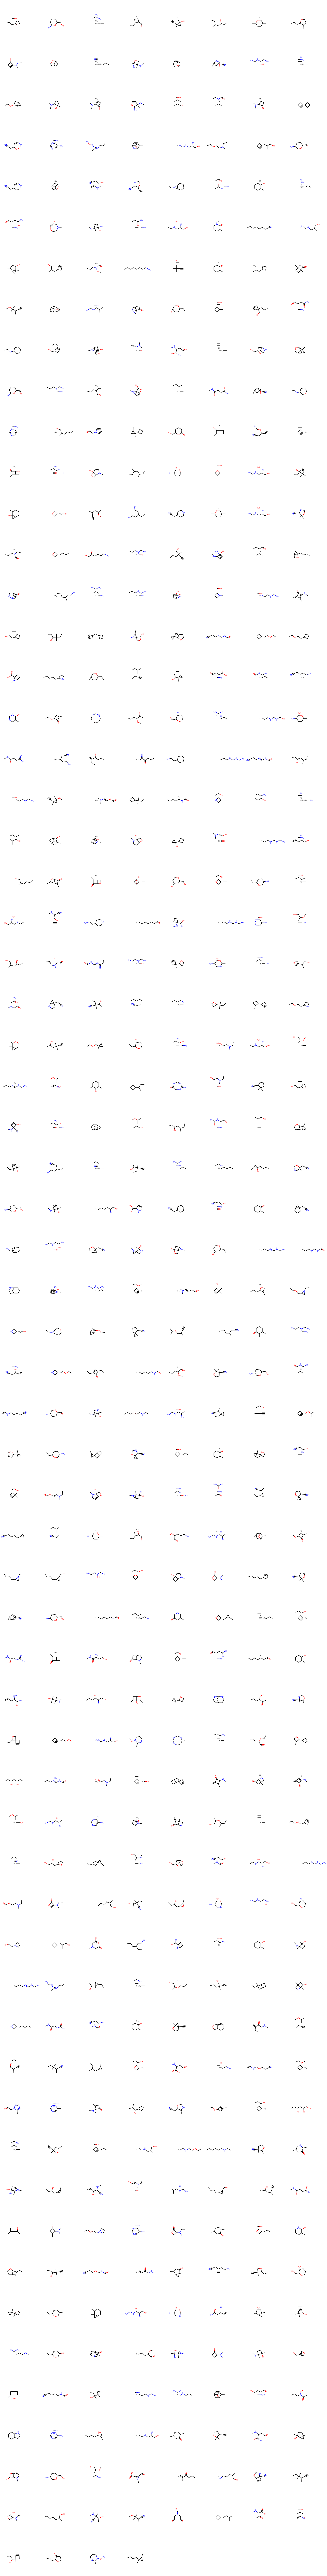

In [40]:
img

In [37]:
df = pd.DataFrame({'SMIELS': data} for data in s)

In [38]:
df.to_csv('quantum-'+str(resume_iters)+'.csv', index=False)